In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
from pathlib import Path
import matplotlib.pyplot as plt
import csv

In [2]:
#데이터셋
DATASET_NAME = 'kfood'
DRIVE_PATH = Path(os.getcwd())
DATASET_PATH = DRIVE_PATH / DATASET_NAME
filepath = DATASET_PATH
print(filepath.exists())

True


In [242]:
#class_label 매칭 딕셔너리로 저장
labels = None
classes = None
with open(filepath / 'class_label.csv','r') as f:
    w = csv.reader(f)
    classes = w.__next__()
    labels = w.__next__()
#print(len(classes), len(labels), classes, labels)
class_to_label = {}
for _class, _label in zip(classes, labels):
    class_to_label[_class] = int(_label)
tf_class_to_label = tf.constant(list(class_to_label.keys()))

In [13]:
def get_image_crop_points(filepath):
    crops = {}
    properties = filepath / "crop_area.properties"
    with open(properties, 'r') as p:
        for row in p:
            name, crop = row.replace("\n", "").replace(" ", "").split("=")
            if name != "" and crop != "":
                #name = name.encode('utf-8')
                crop = crop.split(",")
                if len(crop) >= 4:
                    crop = [int(crop[1]), int(crop[0]), int(crop[3]), int(crop[2])]
                    crops[name] = crop
                elif len(crop) == 2:
                    crop = [0, 0, int(crop[1]), int(crop[0])]
                    crops[name] = crop
            
    return crops

In [16]:
#crop 지점 정보 빼오기
crop_points = {}
class_list = list(filepath.glob("*/*"))
class_list = [class_name for class_name in class_list if class_name.is_dir()]
for class_name in class_list:
    crop_points.update(get_image_crop_points(class_name))

tf_crop_image_names = tf.constant(list(crop_points.keys()), dtype=tf.string)
tf_crop_points = tf.constant(list(crop_points.values()), dtype=tf.uint8)


In [171]:
#데이터셋의 이미지 경로 및 레이블 저장
from glob import glob
image_paths = sorted(glob("kfood/*/*/*"))
image_paths = [image_path for image_path in image_paths if image_path.split("/")[-1].split(".")[-1].lower() in ("png", "jpg", "jpeg")]
#labels = [class_to_label[Path(image_path).parent.stem] for image_path in image_paths]
print(len(image_paths))#, len(labels))


150507


In [218]:
from glob import glob
image_paths = sorted(glob("kfood/*/*/*"))
image_paths = [image_path for image_path in image_paths if image_path.split("/")[-1].split(".")[-1].lower() in ("jpeg", "jpg", "png")]
#labels = [class_to_label[Path(image_path).parent.stem] for image_path in image_paths]
print(len(image_paths))#, len(labels))


150507


In [217]:
#image_paths = sorted(glob("kfood/*/*/*"))
#image_formats = np.unique(np.array([image_path.split("/")[-1].split(".")[-1].lower() for image_path in image_paths]))
#print(image_formats)

['csv' 'jpeg' 'jpg' 'png' 'properties']


In [228]:
def parse_and_crop_image_add_label(tf_filepath):
    
    image = tf.io.read_file(tf_filepath) # 이미지 파일 읽기
    filepath = tf.compat.path_to_str(tf_filepath)
    #format decoding
    image_format = tf.strings.lower(tf.strings.split(filepath, ".")[-1])

    if image_format == "jpeg":
        image = tf.image.decode_jpeg(image, channels=3) # JPEG-encoded -> uint8 tensor (RGB format)
    elif image_format == "png":
        image = tf.image.decode_png(image, channels=3, dtype=tf.uint8)
    else:    
        image = tf.image.decode_image(image, channels=3, expand_animations=False)


    #crop
    image_name = tf.strings.split(tf.strings.split(filepath, "/")[-1], ".")[0]
    tf_image_idx = tf.where(tf_crop_image_names == image_name)
    try:
        image = tf.image.crop_to_bounding_box(image, *tf_crop_points[tf.reshape(tf_image_idx, shape=())])
    except:
        pass
    
    #labeling
    class_name = tf.strings.split(filepath, "/")[-2]
    tf_class_name_idx = tf.where(tf_class_to_label == class_name)
    try:
        label = tf.reshape(tf_class_name_idx, shape=())
    except:
        label = 0
        print("label error")

    return image, int(label)

In [225]:
def resizing_image(image, label):
    return tf.image.resize(image, (224, 224)), label

In [226]:
def make_kfood_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5, batch_size=32, cache=False):

    filenames_dataset = tf.data.Dataset.from_tensor_slices(filepaths)
    dataset = filenames_dataset.map(parse_and_crop_image_add_label)#, num_parallel_calls=n_parse_threads)
    dataset = dataset.map(resizing_image, num_parallel_calls=n_parse_threads)
    #dataset = filenames_dataset.map(spa)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    if batch_size:
        dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [229]:
#데이터셋 생성
dataset = make_kfood_dataset(image_paths, shuffle_buffer_size=10000, n_parse_threads=tf.data.AUTOTUNE)

In [230]:
for images, labels in dataset.take(1):
    print(images[0], labels[0])

2021-12-28 17:23:19.830272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:23:20.157497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:23:20.263829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:23:20.328670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:23:20.356988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:23:21.006035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:23:21.444695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:23:26.728759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


tf.Tensor(
[[[248.      254.      254.     ]
  [249.      255.      255.     ]
  [249.      255.      255.     ]
  ...
  [ 75.88209  69.88209  69.88209]
  [ 76.       72.       71.     ]
  [ 76.       72.       71.     ]]

 [[248.8038  254.8038  254.8038 ]
  [249.      255.      255.     ]
  [249.      255.      255.     ]
  ...
  [ 76.84047  70.84047  70.84047]
  [ 76.       72.       71.     ]
  [ 76.       72.       71.     ]]

 [[249.      255.      255.     ]
  [249.      255.      255.     ]
  [249.      255.      255.     ]
  ...
  [ 77.       71.       71.     ]
  [ 76.       72.       71.     ]
  [ 76.       72.       71.     ]]

 ...

 [[255.      255.      255.     ]
  [255.      255.      255.     ]
  [255.      255.      255.     ]
  ...
  [208.45193 195.85423 162.30714]
  [150.82715 144.5794  121.44562]
  [210.6527  204.66975 189.62508]]

 [[255.      255.      255.     ]
  [255.      255.      255.     ]
  [255.      255.      255.     ]
  ...
  [175.7268  164.82744 134.

떡꼬치


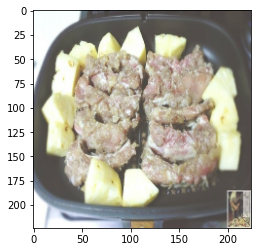

In [256]:
plt.imshow(images[0]/255.)
print(bytes(tf_class_to_label[int(labels[0])].numpy()).decode('utf-8'))